<a href="https://colab.research.google.com/github/SeongjiGo/Noise_Reduction_with_Autoencoder/blob/master/noise_Reduction_with_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Noise_Reduction_with_autoencoder


In [1]:
import matplotlib.pyplot as plt
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data Load


In [3]:
import torch
from torch.utils.data import Dataset

class Classification_Dataset(Dataset):
    def __init__(self, csv, mode, transform=None):
        self.csv = csv.reset_index(drop=True) # random으로 섞인 데이터의 인덱스를 reset 시켜서 다시 부여한다.
        self.transform = transform

    def __len__(self):
        return self.csv.shape[0] # csv 파일의 행 개수 == 데이터 개수

    def __getitem__(self, index):
        row = self.csv.iloc[index] # 주어진 index에 대한 데이터 뽑아오기
        image = Image.open(row.file_path).convert('RGB') # 파일 경로로 부터 이미지를 읽고 rgb로 변환하기
        # print(image.shape)
        # image=np.array(image)
        if self.transform:
            image = self.transform(image) # 이미지에 transform 적용하기

        return image, image # 하나는 모델에 대한 입력, 하나는 재구성을 위해 원본 이미지와 비교하기 위함

In [4]:
import os
from glob import glob
import pandas as pd
import numpy as np
file_path = './drive/MyDrive/noise_reduction_with_autoencoder/dataSet/*/*.png'
file_list = glob(file_path)

data_dict = {'image_name':[], 'file_path':[]}

for path in file_list:
    data_dict['file_path'].append(path)

    path_list = path.split(os.path.sep)
    data_dict['image_name'].append(path_list[-1])

train_df = pd.DataFrame(data_dict)
train_df.to_csv("./drive/MyDrive/noise_reduction_with_autoencoder/train.csv", mode='w')
print('csv파일 생성완료! ')

from sklearn.model_selection import train_test_split

def get_df():
    df = pd.read_csv("./drive/MyDrive/noise_reduction_with_autoencoder/train.csv")
    print('csv 읽기 완료!')
    df_train, df_test = train_test_split(df, test_size = 0.1)
    df_train, df_val = train_test_split(df_train, test_size = 0.2)
    return df_train, df_val, df_test

df_train, df_val, df_test = get_df()
print(f'trainNum: {len(df_train)}, valNum: {len(df_val)}, testNum: {len(df_test)}')




csv파일 생성완료! 
csv 읽기 완료!
trainNum: 216, valNum: 54, testNum: 30


In [5]:
from PIL import Image
from torchvision import transforms
dataset_train = Classification_Dataset(df_train, 'train', transform=transforms.ToTensor())

rgb_mean = [np.mean(x.numpy(), axis=(1, 2)) for x, _ in dataset_train]
rgb_std = [np.std(x.numpy(), axis=(1, 2)) for x, _ in dataset_train]

c_mean = []
c_std = []
for i in range(3):
    c_mean.append(np.mean([m[i] for m in rgb_mean]))
    c_std.append(np.std([s[i] for s in rgb_std]))

print(c_mean)
print(c_std)

transform_train = transforms.Compose([transforms.Resize(224),
                                 # transforms.RandomRotation(30),
                                 # transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize(c_mean, c_std)])


[0.5827904, 0.5464373, 0.5116109]
[0.03177474, 0.02965151, 0.030623147]


In [6]:
dataset_train = Classification_Dataset(df_train, 'train', transform=transforms.ToTensor())
dataset_val = Classification_Dataset(df_val, 'val', transform=transforms.ToTensor())

from torch.utils.data.sampler import RandomSampler
from torch.utils.data import DataLoader

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=4, shuffle=True, num_workers=0, drop_last=True)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=4, shuffle=True, num_workers=0)

print("데이터 로더 완료")

데이터 로더 완료


In [7]:
# plt.plot(1,2,1)

# origin_image = []

# for i, [image,label] in enumerate(train_loader):
#   for j in image:
#     origin_image.append(j)    
#     plt.imshow(np.transpose(j, (1, 2, 0)))
#     plt.show()

encoder + decoder class


In [8]:
dataset_train = Classification_Dataset(df_train, 'train', transform=transform_train)
# dataset_val = Classification_Dataset(df_val, 'val', transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=4, shuffle=True, num_workers=0, drop_last=True)
# val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=4, shuffle=True, num_workers=0)


# 일반 선형 레이어 오토인코더 구조

In [9]:

# import torch
# import torch.nn as nn
# class Encoder(nn.Module):
#     """
#     A simple Convolutional Encoder Model
#     """

#     def __init__(self):
#         super(Encoder, self).__init__()

#         self.conv1 = nn.Conv2d(3, 16, (3, 3), padding=(1, 1))   # 224
#         self.relu1 = nn.ReLU(inplace=True)
#         self.maxpool1 = nn.MaxPool2d((2, 2))                    # 112

#         self.conv2 = nn.Conv2d(16, 32, (3, 3), padding=(1, 1))  
#         self.relu2 = nn.ReLU(inplace=True)
#         self.maxpool2 = nn.MaxPool2d((2, 2))                    # 56

#         self.conv3 = nn.Conv2d(32, 64, (3, 3), padding=(1, 1))  
#         self.relu3 = nn.ReLU(inplace=True)
#         self.maxpool3 = nn.MaxPool2d((2, 2))                    # 28

#         self.conv4 = nn.Conv2d(64, 128, (3, 3), padding=(1, 1)) 
#         self.relu4 = nn.ReLU(inplace=True)
#         self.maxpool4 = nn.MaxPool2d((2, 2))                    # 14

#         self.conv5 = nn.Conv2d(128, 256, (3, 3), padding=(1, 1))
#         self.relu5 = nn.ReLU(inplace=True)
#         self.maxpool5 = nn.MaxPool2d((2, 2))                    # 7

#     def forward(self, x):
#         # Downscale the image with conv maxpool etc.
#         # print(f"decoder - 0Layer shape: {x.shape}")
#         x = self.conv1(x)
#         x = self.relu1(x)
#         x = self.maxpool1(x)

#         # print(f"decoder - 1Layer shape: {x.shape}")
#         x = self.conv2(x)
#         x = self.relu2(x)
#         x = self.maxpool2(x)

#         # print(f"decoder - 2Layer shape: {x.shape}")
#         x = self.conv3(x)
#         x = self.relu3(x)
#         x = self.maxpool3(x)

#         # print(f"decoder - 3Layer shape: {x.shape}")
#         x = self.conv4(x)   
#         x = self.relu4(x)
#         x = self.maxpool4(x)

#         # print(f"decoder - 4Layer shape: {x.shape}")
#         x = self.conv5(x)
#         x = self.relu5(x)
#         x = self.maxpool5(x)
        
#         # print(f"decoder - 5Layer shape: {x.shape}")
#         return x

# class Decoder(nn.Module):
#     def __init__(self):
#         super(Decoder, self).__init__()
#         # self.deconv1 = nn.ConvTranspose2d(256, 128, (2, 2), stride=(2, 2))
#         # self.relu1 = nn.ReLU(inplace=True)

#         # self.deconv2 = nn.ConvTranspose2d(128, 64, (2, 2), stride=(2, 2))
#         # self.relu2 = nn.ReLU(inplace=True)

#         self.deconv3 = nn.ConvTranspose2d(64, 32, (2, 2), stride=(2, 2))
#         self.relu3 = nn.ReLU(inplace=True)

#         self.deconv4 = nn.ConvTranspose2d(32, 16, (2, 2), stride=(2, 2))
#         self.relu4 = nn.ReLU(inplace=True)

#         self.deconv5 = nn.ConvTranspose2d(16, 3, (2, 2), stride=(2, 2))
#         self.relu5 = nn.ReLU(inplace=True)

#     def forward(self, z):
#          # Upscale the image with convtranspose etc.
#         # z = self.deconv1(z)
#         # z = self.relu1(z)

#         # z = self.deconv2(z)
#         # z = self.relu2(z)

#         z = self.deconv3(z)
#         z = self.relu3(z)

#         z = self.deconv4(z)
#         z = self.relu4(z)

#         z = self.deconv5(z)
#         z = self.relu5(z)
#         return z


# U-NET 구조, 참고: https://www.youtube.com/watch?v=sSxdQq9CCx0
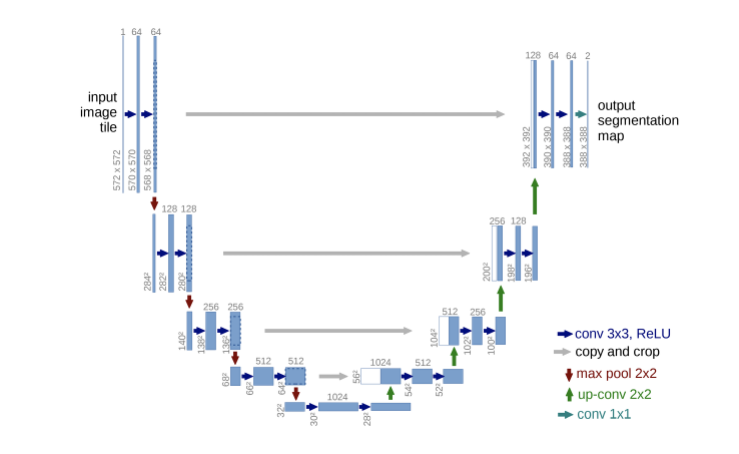

In [10]:
import os
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

lr = 1e-3
batch_size = 4
num_epoch = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # 사진의 파란색 화살표가 공통되므로 함수로 구현 (conv와 ReLU 등)
        def CBR2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = True):
            layers = []
            layers += [nn.Conv2d(in_channels = in_channels, out_channels = out_channels,
                                kernel_size = kernel_size, stride = stride, padding = padding,
                                bias = bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr
    
        # encoder 파트 (UNet 구조의 좌편)
        # enc@_# enc는 encoder부분, @는 첫 번째 스테이지, #은 @스테이지의 화살표 순서
        self.enc1_1 = CBR2d(in_channels=3, out_channels=64) # kernel_size, stride, padding, bias가 항상 고정이므로 디폴트로 설정
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128) # kernel_size, stride, padding, bias가 항상 고정이므로 디폴트로 설정
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256) # kernel_size, stride, padding, bias가 항상 고정이므로 디폴트로 설정
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)
    
        self.enc4_1 = CBR2d(in_channels=256, out_channels=512) # kernel_size, stride, padding, bias가 항상 고정이므로 디폴트로 설정
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels = 512, out_channels=1024)

        # decoder 파트 (UNet 구조의 우편)
        # dec@_#, encoder의 변수명 의미와 동일, 단 대칭을 이루어야 하기 때문에
        # dec@_#의 in_channels는 enc@_#의 out_chennels과 동일해야함. 반대로 out_channels는 enc@_#의 in_chnnels와 동일해야함.
        
        
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)
        
        self.unpool4 = nn.ConvTranspose2d(in_channels = 512, out_channels=512, kernel_size = 2, stride = 2, padding = 0, bias = True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512) # 그림을 보면 512가 아닌 1024로 시작함
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128 , kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64 , kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2*64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=1, stride=1, padding=0, bias=True)

    # enc, dec 연결
    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)
        # print('enc1통과')

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)
        # print('enc2통과')

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)
        # print('enc3통과')

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)
        # print('enc4통과')

        enc5_1 = self.enc5_1(pool4)
        #################### decoder ########################
        dec5_1 = self.dec5_1(enc5_1)
        # print('dec5통과')

        unpool4 = self.unpool4(dec5_1)
        # print(f'unpool4 shape: {unpool4.shape}\nenc4_2 shape: {enc4_2.shape}')
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        # print('dec4통과')
        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)
        # print('dec3통과')

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)
        # print('dec2통과')

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)
        # print('dec1통과')

        x = self.fc(dec1_1)
        return x


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

unet = UNet().to(device)

loss_func = nn.MSELoss()
parameters = unet.parameters()
optimizer = torch.optim.Adam(parameters, lr = lr)

# num_epoch = int(input("Input Epoch num: "))

num_data_train = len(df_train)
num_data_val = len(df_val)

num_batch = 4

fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x, mean, std: (x*std) + mean
fn_class = lambda x : 1.0 * (x > 0.5)


In [12]:
from tqdm import tqdm

minLoss = 10000
out_img = []
for epoch in range(10):
    unet.train()
    loss_arr = []

    for j,[image,label] in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        image = image.to(device)
        output = unet(image)

        loss = loss_func(output, image)
        loss.backward()
        optimizer.step()

        loss_arr += [loss.item()]
        
        label = fn_tonumpy(label)
        image = fn_tonumpy(fn_denorm(image, mean=np.mean(c_mean), std=np.mean(c_std)))
        output = fn_tonumpy(fn_denorm(output, mean=np.mean(c_mean), std=np.mean(c_std)))

    if np.mean(loss_arr) < minLoss:
        torch.save(unet, '/content/drive/MyDrive/noise_reduction_with_autoencoder/best_model.pth')
        minLoss = np.mean(loss_arr)
        
    print(f"TRAIN: EPOCH {epoch} / {num_epoch} | LOSS {np.mean(loss_arr)}")
    
# for i in range(num_epoch):
#     for j,[image,label] in enumerate(tqdm(train_loader)) :
#         optimizer.zero_grad()
#         image = image.to(device)

#         output = encoder(image)
#         output = decoder(output)

#         loss = loss_func(output, image)
#         loss.backward()
#         optimizer.step()

    
#     print(f'Epochs: {i} MSELoss: {loss}')

100%|██████████| 54/54 [00:35<00:00,  1.52it/s]


TRAIN: EPOCH 0 / 100 | LOSS 31.743748841462313


100%|██████████| 54/54 [00:35<00:00,  1.54it/s]


TRAIN: EPOCH 1 / 100 | LOSS 12.549395517066673


100%|██████████| 54/54 [00:35<00:00,  1.54it/s]


TRAIN: EPOCH 2 / 100 | LOSS 4.000203333519123


100%|██████████| 54/54 [00:35<00:00,  1.54it/s]


TRAIN: EPOCH 3 / 100 | LOSS 1.5118639480184626


100%|██████████| 54/54 [00:35<00:00,  1.54it/s]


TRAIN: EPOCH 4 / 100 | LOSS 1.1047719750139449


100%|██████████| 54/54 [00:35<00:00,  1.53it/s]


TRAIN: EPOCH 5 / 100 | LOSS 0.9442772970155433


100%|██████████| 54/54 [00:35<00:00,  1.53it/s]


TRAIN: EPOCH 6 / 100 | LOSS 0.8057728622246672


100%|██████████| 54/54 [00:35<00:00,  1.54it/s]


TRAIN: EPOCH 7 / 100 | LOSS 0.7719045140677028


100%|██████████| 54/54 [00:35<00:00,  1.53it/s]


TRAIN: EPOCH 8 / 100 | LOSS 0.8073914470496001


100%|██████████| 54/54 [00:35<00:00,  1.54it/s]


TRAIN: EPOCH 9 / 100 | LOSS 0.6022920503660485


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


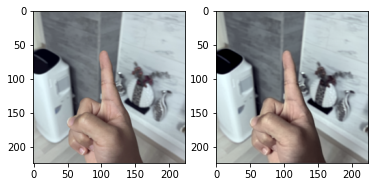

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


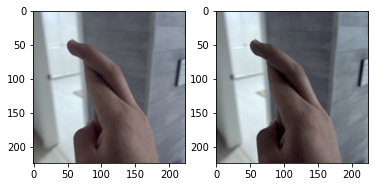

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


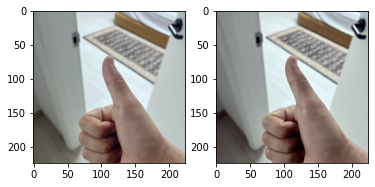

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


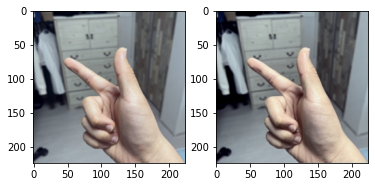

In [13]:
import matplotlib.pyplot as plt
import numpy as np


# output = output.to(device)



for i in range(4):
  plt.subplot(1, 2, 1)
  plt.imshow(image[i])
  
  
  plt.subplot(1, 2, 2)
  plt.imshow(output[i])
  plt.show()


In [19]:


noise_force = 0.1
sample_Image = image[0:]
train_noisy = []
noise_epochs = 50
for i in range(len(sample_Image)):
    train_noisy.append(sample_Image[i] + noise_force * np.random.normal(loc=0.0, scale=1.0, size=sample_Image[i].shape))

# train_noisy = np.clip(train_noisy, 0., 1.) # 0보다 아래인건 0, 1보다 큰건 1
image = torch.tensor(image)
out_img = []
for i in range(noise_epochs):
    for j,img in enumerate(tqdm(train_noisy)) :
        optimizer.zero_grad()

        img = torch.tensor(img)
        
        img = img.unsqueeze(0)
        
        img = img.float()        
        img = np.transpose(img, (0, 3, 1, 2))
        img = img.to(device)
        delete_noise = unet(img)
        # sample_Image[j] = sample_Image[j].unsqueeze(0)

        delete_noise = delete_noise.to(device)
        temp_image = np.transpose(sample_Image[j], (2, 1, 0))
        temp_image = torch.tensor(temp_image)
        temp_image = temp_image.to(device)

        loss_func.to(device)
        loss = loss_func(delete_noise, temp_image)
        loss.backward()
        optimizer.step()

        if i == noise_epochs-1:
          out_img.append(delete_noise)
        # sample_Image = fn_tonumpy(fn_denorm(sample_Image, mean=np.mean(c_mean), std=np.mean(c_std)))
        # delete_noise = fn_tonumpy(fn_denorm(delete_noise, mean=np.mean(c_mean), std=np.mean(c_std)))

    print(f'Epochs: {i} MSELoss: {loss}')

# for img in train_noisy:

#     plt.imshow(np.transpose(img, (1, 2, 0))) # rgb채널을 1차원으로 변환 (imshow 조건)
#     plt.show()
    
#     # img = img.transpose(1, 2, 0)

#     # img = Image.fromarray((img * 255).astype(np.uint8))
#     # img = transform_noise(img)
    
#     # img = img.view(1, 224, 224, 3)
#     # img = np.transpose(img, (0, 3, 1, 2))
#     # img = img.to(device)


#     # z = encoder(img)
#     # output = decoder(z)
#     output = np.squeeze(output)

#     plt.imshow(np.transpose(output.cpu().detach().numpy(), (1, 2, 0)))
#     plt.show()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([3, 224,

Epochs: 0 MSELoss: 0.010187914595007896


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epochs: 1 MSELoss: 0.009500806219875813


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epochs: 2 MSELoss: 0.009261096827685833


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Epochs: 3 MSELoss: 0.008979802019894123


100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


Epochs: 4 MSELoss: 0.009033559821546078


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epochs: 5 MSELoss: 0.008640521205961704


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Epochs: 6 MSELoss: 0.008687511086463928


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epochs: 7 MSELoss: 0.008514154702425003


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Epochs: 8 MSELoss: 0.008414926938712597


100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


Epochs: 9 MSELoss: 0.00854324921965599


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Epochs: 10 MSELoss: 0.008632158860564232


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epochs: 11 MSELoss: 0.008977253921329975


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epochs: 12 MSELoss: 0.008806462399661541


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Epochs: 13 MSELoss: 0.008707160130143166


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epochs: 14 MSELoss: 0.00845702737569809


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epochs: 15 MSELoss: 0.008328460156917572


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Epochs: 16 MSELoss: 0.008406023494899273


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Epochs: 17 MSELoss: 0.008448786102235317


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epochs: 18 MSELoss: 0.008031817153096199


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Epochs: 19 MSELoss: 0.007968788966536522


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epochs: 20 MSELoss: 0.008131864480674267


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Epochs: 21 MSELoss: 0.008890494704246521


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epochs: 22 MSELoss: 0.008715464733541012


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Epochs: 23 MSELoss: 0.008225512690842152


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Epochs: 24 MSELoss: 0.008155442774295807


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Epochs: 25 MSELoss: 0.007950684055685997


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Epochs: 26 MSELoss: 0.007917951792478561


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epochs: 27 MSELoss: 0.008014097809791565


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Epochs: 28 MSELoss: 0.00873201061040163


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epochs: 29 MSELoss: 0.008016275241971016


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Epochs: 30 MSELoss: 0.00781090697273612


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Epochs: 31 MSELoss: 0.007655146066099405


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Epochs: 32 MSELoss: 0.0073422095738351345


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epochs: 33 MSELoss: 0.007230969145894051


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Epochs: 34 MSELoss: 0.007214226759970188


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epochs: 35 MSELoss: 0.007083768490701914


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Epochs: 36 MSELoss: 0.006846530828624964


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Epochs: 37 MSELoss: 0.006855443120002747


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Epochs: 38 MSELoss: 0.006774968933314085


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epochs: 39 MSELoss: 0.0067533771507442


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Epochs: 40 MSELoss: 0.006785654928535223


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epochs: 41 MSELoss: 0.00693868100643158


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Epochs: 42 MSELoss: 0.007159981410950422


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Epochs: 43 MSELoss: 0.0072699799202382565


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Epochs: 44 MSELoss: 0.00758623331785202


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epochs: 45 MSELoss: 0.007520200219005346


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Epochs: 46 MSELoss: 0.007184966932982206


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Epochs: 47 MSELoss: 0.006786568555980921


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Epochs: 48 MSELoss: 0.006617542821913958


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epochs: 49 MSELoss: 0.006819592788815498


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


before


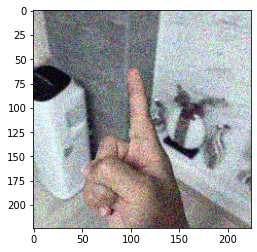

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


after
(1, 3, 224, 224)


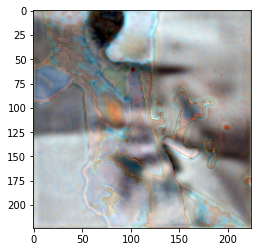

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


before


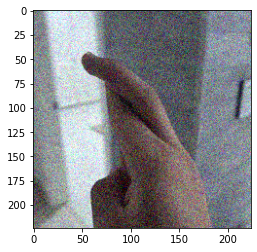

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


after
(1, 3, 224, 224)


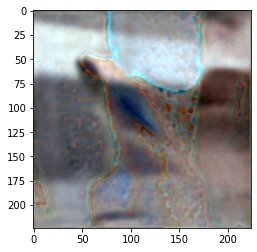

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


before


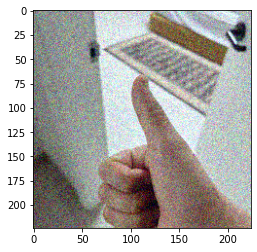

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


after
(1, 3, 224, 224)


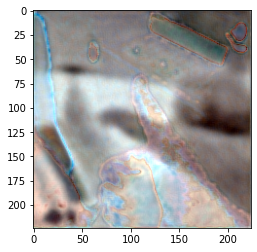

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


before


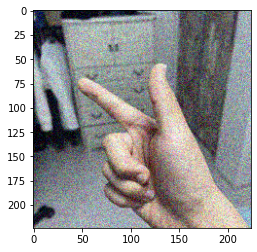

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


after
(1, 3, 224, 224)


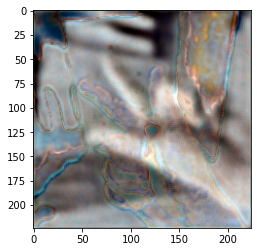

In [22]:
for i in range(4):
    print("before")
    temp = train_noisy[i]
    plt.imshow(temp)
    plt.show()
    
    print("after")
    temp_result = out_img[i].cpu().detach().numpy()
    print(temp_result.shape)
    temp_result = np.transpose(temp_result.squeeze(), (1, 2, 0))
    plt.imshow(temp_result)
    plt.show()